## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# Import necessary packages and load the model.

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  train_test_split

In [2]:


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Using the data by mounting the google drive to run the model in Google Collab

from google.colab import drive
drive.mount('/gdrive')

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /gdrive


In [4]:
# Opening JSON file 
# Write the path to your data file and load it 

filePath = open('/gdrive/MyDrive/Colab Notebooks/Automatic Ticket Classification Assignment/data/complaints-2021-05-14_08_16.json')
# filePath = open('/content/drive/MyDrive/NLP_Automatic_Ticket_Classification/Data/complaints-2021-05-14_08_16.json')

In [5]:
# returns JSON object as a dictionary 

data = json.load(filePath)
df = pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
# Lets check the shape of dataframe

df.shape

(78313, 22)

In [8]:
# print the column names

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
#Assign new column names

df.columns = [x[1:] for x in df.columns]
df.columns = [x.replace('source.', '') for x in df.columns]

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
# Lets check the total complaints which have blank values

lst = [np.nan for x in df['complaint_what_happened'].values if x=='']
print(len(lst))

57241


In [11]:
# Assign nan in place of blanks in the complaints column

df.loc[df['complaint_what_happened']=='', 'complaint_what_happened'] = np.nan

In [12]:
# Remove all rows where complaints column is nan

ticket_df = df[~df['complaint_what_happened'].isnull()]
print(ticket_df.shape)

(21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
    text = text.lower()
    text = re.sub("\[.*?\]",'', text)
    text = re.sub("[^\w\s]", '', text)
    text = re.sub("\S*\d\S*", '', text)
    return text

In [14]:
#Write your function to Lemmatize the texts

def lemmatize_text(text):
    tokens = word_tokenize(text);
    wordnet_lemmatizer = WordNetLemmatizer();
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens if not token in set(stopwords.words('english'))]
    return " ".join(lemmatized)

In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = pd.DataFrame(columns=['complaints', 'lemmatized_complaints'])

for i in range(ticket_df.shape[0]):
    df_clean.loc[i] =  [ticket_df.iloc[i]['complaint_what_happened'], lemmatize_text(clean_text(ticket_df.iloc[i]['complaint_what_happened']))]

df_clean.shape

(21072, 2)

In [16]:
# Print head of dataframe after text cleaning and lemmatization

df_clean.head(5)

,complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...


In [17]:
# Write your function to extract the POS tags 

def extract_pos_tag(text):
    doc = nlp(text)
    result = []
    for token in doc:
        if(token.pos_=='NOUN'):
            result.append(token.text)
    return " ".join(result)

In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.

df_clean['complaints_with_removed_pos'] = ''
for i in range(ticket_df.shape[0]):
    df_clean.loc[i, 'complaints_with_removed_pos'] = extract_pos_tag(df_clean.iloc[i]['lemmatized_complaints'])

In [20]:
# Print head of dataframe after removing POS tags on complaints

df_clean.head(5)

,complaints,lemmatized_complaints,complaints_with_removed_pos
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




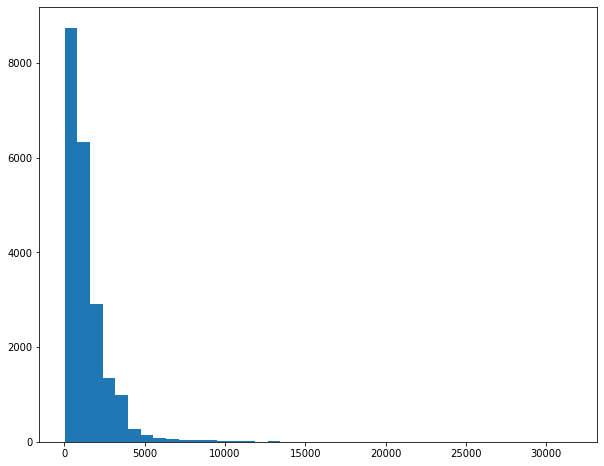

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,8))
# comp_len = [len(d) for d in df_clean.complaints_with_removed_pos]
comp_len = [len(d) for d in df_clean.complaints]
plt.hist(comp_len, bins = 40)

plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

# stopwordslist = set(stopwords.words("english"))
# print(stopwordslist)

WC = WordCloud(max_words=40).generate(str(df_clean.complaints_with_removed_pos))

print(WC.words_)

{'card': 1.0, 'credit': 0.5714285714285714, 'son': 0.42857142857142855, 'account': 0.42857142857142855, 'pay': 0.42857142857142855, 'name': 0.2857142857142857, 'chase': 0.2857142857142857, 'agent': 0.2857142857142857, 'information': 0.2857142857142857, 'ticket': 0.2857142857142857, 'money': 0.2857142857142857, 'year': 0.2857142857142857, 'morning': 0.14285714285714285, 'debt': 0.14285714285714285, 'verification': 0.14285714285714285, 'statement': 0.14285714285714285, 'anniversary': 0.14285714285714285, 'date': 0.14285714285714285, 'application': 0.14285714285714285, 'identity': 0.14285714285714285, 'consent': 0.14285714285714285, 'service': 0.14285714285714285, 'cred': 0.14285714285714285, 'offer': 0.14285714285714285, 'reward': 0.14285714285714285, 'check': 0.14285714285714285, 'time': 0.14285714285714285, 'customer': 0.14285714285714285, 'decade': 0.14285714285714285, 'solicitation': 0.14285714285714285, 'provider': 0.14285714285714285, 'claim': 0.14285714285714285, 'purchase': 0.142

In [23]:
# Top 40 words by frequency using word cloud

wordCloud_df = pd.DataFrame(list(WC.words_.items()), columns={'word', 'frequency_score'})
wordCloud_df

,word,frequency_score
0,card,1.000000
1,credit,0.571429
2,son,0.428571
3,account,0.428571
4,pay,0.428571
5,name,0.285714
6,chase,0.285714
7,agent,0.285714
8,information,0.285714
9,ticket,0.285714


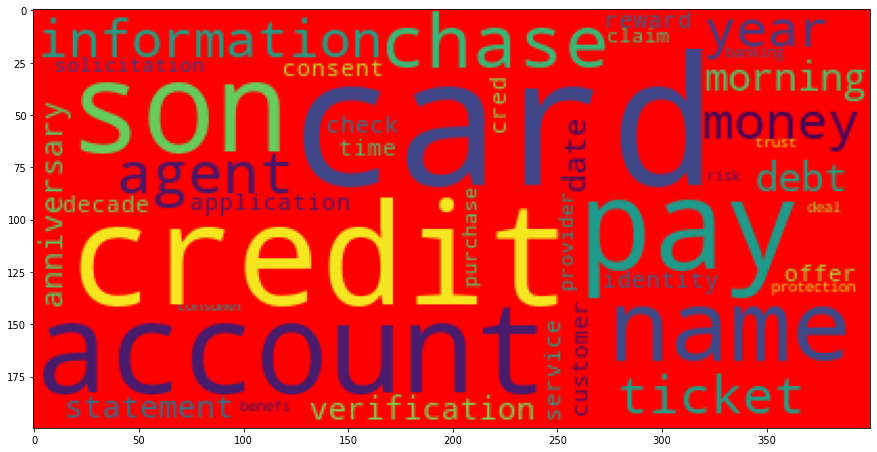

In [24]:
# Visualise the top words by frequency using word cloud

fig = plt.figure(figsize=(15,12))
WC.background_color = 'Red'
plt.imshow(WC)
plt.show();

In [25]:
#Removing -PRON- from the text corpus

df_clean['complaint_clean'] = df_clean['complaints_with_removed_pos'].str.replace('-PRON-', '')
df_clean.head()

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# Function to get ngrams - unigrams, bigrams and trigrams

def extract_top_ngram(cleaned_text_corpus, n_gram, top_ngram_count):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram),stop_words='english')
    bow = vec.fit_transform(cleaned_text_corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[0:top_ngram_count]

In [27]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

unigram_df = pd.DataFrame(extract_top_ngram(df_clean['complaint_clean'], 1, 30))
unigram_df.rename(columns = {0:'Unigram', 1:'Count'}, inplace=True)

In [28]:
# Print the top 10 words in the unigram frequency

unigram_df.iloc[:10,:]

,Unigram,Count
0,account,41436
1,chase,34561
2,credit,30348
3,card,29673
4,payment,20454
5,time,15698
6,charge,12156
7,money,11590
8,day,10628
9,check,10098


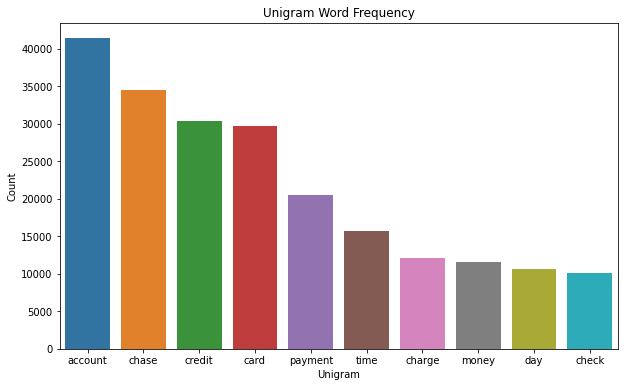

In [29]:
# Visualise the unigrams using barplot

plt.figure(figsize=(10,6))
sns.barplot(x='Unigram', y='Count', data=unigram_df.iloc[:10,:])
plt.title('Unigram Word Frequency')
plt.show()

In [30]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

bigram_df = pd.DataFrame(extract_top_ngram(df_clean['complaint_clean'], 2, 30))
bigram_df.rename(columns = {0:'Bigram', 1:'Count'}, inplace=True)

In [31]:
# Print the top 10 words in the bigram frequency
bigram_df.iloc[:10, :]

,Bigram,Count
0,credit card,12150
1,credit report,3461
2,account account,2722
3,customer service,2450
4,chase credit,2213
5,card account,1787
6,account chase,1774
7,chase account,1746
8,credit score,1642
9,payment payment,1577


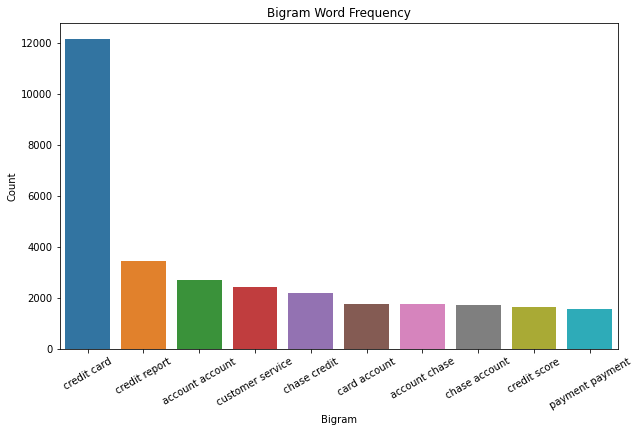

In [32]:
# Visualise the bigrams using barplot

plt.figure(figsize=(10,6))
sns.barplot(x='Bigram', y='Count', data=bigram_df.iloc[:10,:])
plt.xticks(rotation=30)
plt.title('Bigram Word Frequency')
plt.show()

In [33]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

trigram_df = pd.DataFrame(extract_top_ngram(df_clean['complaint_clean'], 3, 30))
trigram_df.rename(columns = {0:'Trigram', 1:'Count'}, inplace=True)

In [34]:
# Print the top 10 words in the trigram frequency

trigram_df.iloc[:10,:]

,Trigram,Count
0,chase credit card,1490
1,credit card account,1045
2,credit card company,865
3,credit card chase,671
4,credit card credit,638
5,card credit card,551
6,account credit card,453
7,inquiry credit report,392
8,charge credit card,380
9,credit report credit,362


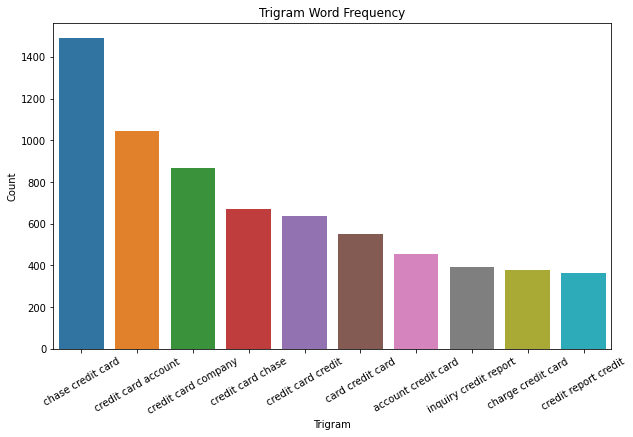

In [35]:
# Visualise the trigrams using barplot

plt.figure(figsize=(10,6))
sns.barplot(x='Trigram', y='Count', data=trigram_df.iloc[:10,:])
plt.xticks(rotation=30)
plt.title('Trigram Word Frequency')
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
# Lets first check the records which have XXXX in it.

df_clean[df_clean['complaint_clean'].str.contains('xxxx')].head(5)

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
12,I opened an account with chase bank on XXXX an...,opened account chase bank xxxx used code xxxx ...,bonus account deposit bonus day xxxx deposit a...,bonus account deposit bonus day xxxx deposit a...
15,I opened the saving account for the {$25.00} b...,opened saving account bonus supposed received ...,account bonus bonus auto transfer checking sav...,account bonus bonus auto transfer checking sav...
20,"JP Morgan Chase Bank, please answer the follow...",jp morgan chase bank please answer following q...,question information reason information routin...,question information reason information routin...
24,I made a purchase of {$260.00} on XX/XX/XXXX. ...,made purchase xxxxxxxx made payment xxxxxxxx x...,purchase xxxxxxxx payment closing date xxxxxxx...,purchase xxxxxxxx payment closing date xxxxxxx...


In [37]:
# Remove XXXX

df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [38]:
# All masked texts has been removed

df_clean.head(5)

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
# Write your code here to initialise the TfidfVectorizer 

tfidf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

doc_term_matrix= tfidf_vect.fit_transform(df_clean['complaint_clean'])
doc_term_matrix.shape

(21072, 5903)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [41]:
# Import vectorizers and NMF model

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [42]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5

# keep the random_state =40
nmf_model = NMF(n_components = 5, random_state = 40)

In [43]:
# Extract W(doc X topics) and H(topics X terms) matrix

W = nmf_model.fit_transform(doc_term_matrix)  # Document-topic matrix
H = nmf_model.components_  

In [44]:
# Print the Top15 words for each of the topics

words = np.array(tfidf_vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,fund,bank,deposit,chase,branch,day,number,business,transfer,customer,transaction,time
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,application,debt,year,balance,information,letter
Topic 3,payment,balance,month,fee,statement,pay,date,time,day,chase,auto,error,credit,car,year
Topic 4,charge,card,transaction,chase,dispute,merchant,fee,claim,fraud,purchase,service,email,time,refund,phone
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure


In [45]:
# Lets check the probability of topics for a particular document and corresponding topic with highest probability

print(W[0])
print(W[0].argmax())

[0.00735585 0.01092199 0.00750994 0.00833873 0.03040528]
4


In [47]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

print(W.argmax(axis=1))

[4 3 1 ... 3 2 2]


In [48]:
# Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic_ID'] = W.argmax(axis=1)
df_clean.shape

(21072, 5)

In [49]:
# Check the head of the dataframe with new Topic ID column

df_clean.head()

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean,Topic_ID
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,3
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0


In [50]:
# Print the first 5 Complaint for each of the Topics

df_clean_top5 = df_clean.groupby('Topic_ID').head(5)
df_clean_top5.sort_values('Topic_ID')

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean,Topic_ID
12,I opened an account with chase bank on XXXX an...,opened account chase bank xxxx used code xxxx ...,bonus account deposit bonus day xxxx deposit a...,bonus account deposit bonus day deposit accou...,0
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,card branch customer service representative ac...,card branch customer service representative ac...,0
15,I opened the saving account for the {$25.00} b...,opened saving account bonus supposed received ...,account bonus bonus auto transfer checking sav...,account bonus bonus auto transfer checking sav...,0
10,mishandling of this account by Chase auto and ...,mishandling account chase auto xxxx,,,0
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
5,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,credit card data credit report company issue,credit card data credit report company issue,1
11,I have reached out to XXXX several times in at...,reached xxxx several time attempt fraudulent i...,time inquiry need call contact creditor inquir...,time inquiry need call contact creditor inquir...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [51]:
# Lets print top 25 words for each of the topics to determine the possible Labels

words = np.array(tfidf_vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 25)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(25)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:25]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25
Topic 1,account,check,money,fund,bank,deposit,chase,branch,day,number,business,transfer,customer,transaction,time,reason,information,balance,phone,claim,fee,access,fraud,checking,person
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,application,debt,year,balance,information,letter,reporting,reason,identity,bureau,point,history,time,month,line,theft
Topic 3,payment,balance,month,fee,statement,pay,date,time,day,chase,auto,error,credit,car,year,account,history,plan,issue,record,option,customer,period,bank,lease
Topic 4,charge,card,transaction,chase,dispute,merchant,fee,claim,fraud,purchase,service,email,time,refund,phone,statement,company,customer,day,number,case,debit,item,letter,investigation
Topic 5,loan,mortgage,modification,chase,home,year,property,rate,time,document,letter,sale,debt,information,foreclosure,process,tax,month,application,income,company,request,complaint,attorney,insurance


**FINDINGS:**

1. Topic 1 : We find frequent words like Account, Deposit, Branch,Customer,transaction,Transfer, time/day,manager etc. This is more relevant to general Account Services.Lets Label this topic as "Bank Account services".

2. Topic 2:  We find frequent words like Credit, Card,Balance,,Score,Limit,Application,Letter,bureau,History etc. These are more related to Credit Card related services. Lets label this topic as "Credit card or prepaid card".

3. Topic 3:  We find frequent words in this topic which are more kind of mixxed.So it is not very clear and easy to decide that the words in the topic are related to specific Banking service. SO lets Label this as "Others".

4. Topic 4:  We find frequent words like dispute,claim,refund,investigation,Fraud,Case,Chase, These are more related Dispute/Fradu.SO lets Label this as "Theft/Dispute Reporting".

5. Topic 5:  We find frequent words like mortgage , Loan,property,foreclosure,Tax,attorney. These are more related Mortgage and Loan. SO lets Label this as "Mortgage/Loan""


In [52]:
# Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"  }

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic_ID'].map(Topic_names)

In [53]:
df_clean.head(5)

,complaints,lemmatized_complaints,complaints_with_removed_pos,complaint_clean,Topic_ID,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,4,Mortgage/Loan
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card told agent upgrade ann...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,3,Theft/Dispute Reporting
2,Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,card application identity consent service cred...,card application identity consent service cred...,1,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",trying book xxxx xxxx ticket came across offer...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check account money son money pay son time...,son check account money son money pay son time...,0,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
# Keep the columns "complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data=df_clean[["complaint_clean","Topic_ID"]]
training_data.head(5)

,complaint_clean,Topic_ID
0,morning name chase debt verification statement...,4
1,card agent anniversary date agent information ...,3
2,card application identity consent service cred...,1
3,ticket offer ticket reward card information of...,1
4,son check account money son money pay son time...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [55]:
# Write your code to get the Vector count

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(training_data['complaint_clean'])

# Write your code here to transform the word vector to tf-idf
tfidf_transf = TfidfTransformer()
X_train_tfidf = tfidf_transf.fit_transform(X_train_counts)

In [56]:
# The final processed training data that can be used in model building

X = X_train_tfidf
y = training_data.Topic_ID

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [57]:
# Write your code here to build any 3 models and evaluate them using the required metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)


In [58]:
# Lets check the shape of training and test data

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14750, 12655)
(14750,)
(6322, 12655)
(6322,)


**Logistic Regression**

In [59]:
# Let's STart with Logistic Regression First

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [60]:
# Logistic Regression model with grid search cross validation technique to get the best parameters and best performance score

lr = LogisticRegression()

lr_params = {
            'C': [0.01, 0.1, 1, 2, 3, 4, 5, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['newton-cg', 'liblinear', 'sag']
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

lr_grid_search = GridSearchCV(estimator=lr, 
                         param_grid=lr_params,
                         cv=folds,
                         verbose=1,
                         n_jobs=-1)

lr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 2, 3, 4, 5, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'liblinear', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=Non

In [61]:
# The best model parameters and best score

print("best parameters- {}".format(lr_grid_search.best_params_))
print("best score- {}".format(lr_grid_search.best_score_))

best parameters- {'C': 5, 'penalty': 'l2', 'solver': 'sag'}
best score- 0.9590508474576271


In [62]:
# Predict the model using test data and find f1 score

y_pred = lr_grid_search.predict(X_test)

f1_lr = round(f1_score(y_test,y_pred, average='weighted'), 3)
print("F1 Score is {}".format(f1_lr))

F1 Score is 0.957


**Decision Tree**

In [63]:
# Let's try with Decisions Tree

from sklearn.tree import DecisionTreeClassifier

In [64]:
# Decision Tree model with grid search cross validation technique to get the best parameters and best performance score

dt = DecisionTreeClassifier()

dt_params = {'max_depth': [10,15,20],
            'min_samples_leaf': [1,2,3,5],
            'min_samples_split': [1,2,3,4,5],
             'splitter': ['best', 'random'],
            'criterion': ['entropy']
             }

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

dt_grid_search = GridSearchCV(estimator=dt,
                    param_grid=dt_params,
                    cv=folds,
                    n_jobs=-1,
                    verbose=1)

dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
         

In [65]:
# The best model parameters and best score

print("best parameters- {}".format(dt_grid_search.best_params_))
print("best score- {}".format(dt_grid_search.best_score_))

best parameters- {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 4, 'splitter': 'best'}
best score- 0.8316610169491525


In [66]:
# Predict the model using test data and find f1 score

y_pred = dt_grid_search.predict(X_test)

f1_dt = round(f1_score(y_test,y_pred, average='weighted'), 3)
print("F1 Score is {}".format(f1_dt))

F1 Score is 0.828


**Random Forest**

In [67]:
# Lets Try with Random Forest

from sklearn.ensemble import RandomForestClassifier

In [68]:
# Random Forest model with grid search cross validation technique to get the best parameters and best performance score

rf = RandomForestClassifier()

rf_param = {
            'min_samples_split': [1,2,5],
            'min_samples_leaf': [1,2,5],
            'n_estimators': [50,100,150],
            'criterion': ['entropy']
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

rf_grid_search = GridSearchCV(estimator=rf,
                              param_grid=rf_param,
                              cv=folds,
                              n_jobs=-1,
                              verbose=1)

rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [69]:
# The best model parameters and best score

print("best parameters- {}".format(rf_grid_search.best_params_))
print("best score- {}".format(rf_grid_search.best_score_))

best parameters- {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
best score- 0.8575593220338984


In [70]:
# Predict the model using test data and find f1 score

y_pred = rf_grid_search.predict(X_test)

f1_rf = round(f1_score(y_test,y_pred, average='weighted'), 3)
print("F1 Score is {}".format(f1_rf))

F1 Score is 0.856


**Naive Bayes**

In [71]:
# Lets Try with Navia Bias
from sklearn.naive_bayes import MultinomialNB


In [72]:
# Naive Bayes model with grid search cross validation technique to get the best parameters and best performance score

nb = MultinomialNB()

nb_param = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

nb_grid_search = GridSearchCV(estimator=nb,
                              param_grid=nb_param,
                              cv=folds,
                              n_jobs=-1,
                              verbose=1)

nb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [73]:
# The best model parameters and best score

print("best parameters- {}".format(nb_grid_search.best_params_))
print("best score- {}".format(nb_grid_search.best_score_))

best parameters- {'alpha': 0.1}
best score- 0.7846779661016949


In [74]:
# Predict the model using test data and find f1 score

y_pred = nb_grid_search.predict(X_test)

f1_nb = round(f1_score(y_test,y_pred, average='weighted'), 3)
print("F1 Score is {}:".format(f1_nb))

F1 Score is 0.777:


### Model Comparision 
Let's compare all the models with respect to the f1 score and choose the best model for our prediction and model inference

In [75]:
# Create dataframe of model's performance score

f1_score_df = pd.DataFrame(index={'f1_Logistic_Regression', 'f1_Decision_Tree', 'f1_Random_Forest', 'f1_Naive_Bayes'}, columns={'f1_score'})
f1_score_df['f1_score'] = [f1_lr, f1_dt, f1_rf, f1_nb]
f1_score_df

,f1_score
f1_Logistic_Regression,0.957
f1_Decision_Tree,0.828
f1_Random_Forest,0.856
f1_Naive_Bayes,0.777


**Findings**:
1. It is obvious from the above f1_score dataframe that Logistic Regression is giving the best performance among all the other models.
2. When moved from Decision tree to Random forest, f1 score has been improved however it is less than Logistic regression.
3. Naive Bayes model is giving worst performance among all, hence not recommended.

**Conclusion:** We should go with Logistic Regression for our model inference

## Model Inference
Apply the best model to predict a custom text to see its performance. 

In [114]:
# Let's take some sample text corpus from various online complaint forums

test_sample_corpus = [
                      'I am writing this to dispute an incorrect charge on my bill. I dispute this charge because I have been charged twice for the same item. The purchase at Abc restaurant dated 3rd February 2014 has been charged twice. I have been a credit card holder of your bank since the past 7 years and have always received remarkable service. I hope that this dispute would be solved soon. I would sincerely appreciate your prompt assistance in this matter.',
                      'The issue of inflexibility on the bank\'s part to adjust the EMI amount or tenure in case of an interest rate revision',
                      'The amount was deducted on 30th March 2020 at 3:34 pm with my debit card ending with *****5269. The same was done without asking for my consent or an OTP request. Furthermore, ensure that the deducted amount is refunded in my account immediately.',
                      'I made my creditcard payment on 5th may 2020 via cheque. what happened was my credit card was blocked and i did not receive my new card . On my credit card statement the last four digits of my new card were mentioned so I thought that only last four digits of the card are changed and rest of the number is same but in actual last 8 digits of the card were changed so I changed just the last four digits and kept the previous digits unchanged and made the payment',
                      'I saw an ad of netflix saying that \"try us free for 30 days! You won\'t be charged until after your free month..." but they charged me'
                      ]


# Create the dataframe of sample text corpus

model_infer_df = pd.DataFrame()
model_infer_df['complaints'] = test_sample_corpus


# Lets do the preprocessing of sample text and convert into tfidf transformed data

model_infer_df['clean_text'] = [extract_pos_tag(lemmatize_text(clean_text(complaint))) for complaint in model_infer_df.complaints]
test_sample_vect = tfidf_transf.transform(count_vec.transform(model_infer_df.clean_text))

In [117]:
# Predict the topic/classification of the sample text with our best model - Logistic Regression

model_infer_df['output'] = lr_grid_search.predict(test_sample_vect)
model_infer_df['topic'] = model_infer_df['output'].map(Topic_names)

In [118]:
# Let's see the inference of the model for sample complaint text

model_infer_df

,complaints,clean_text,output,topic
0,I am writing this to dispute an incorrect char...,dispute charge dispute charge item purchase re...,3,Theft/Dispute Reporting
1,The issue of inflexibility on the bank's part ...,part amount tenure case interest rate revision,4,Mortgage/Loan
2,The amount was deducted on 30th March 2020 at ...,amount card consent otp request amount account,0,Bank Account services
3,I made my creditcard payment on 5th may 2020 v...,payment cheque credit card card credit card st...,1,Credit card or prepaid card
4,"I saw an ad of netflix saying that ""try us fre...",day month,2,Others


**Conclusion:** We can conclude from the above model inference that model is predicting almost correct topic/classifications over various complaints. However we can train the model for larger corpus of data to get more accurate result. But for the given data set, model is performing pretty well.